In [1]:
VERSION = 'v1.0'

# Model Details
## Features:
- One hot encoded **day of week** and **month** (not year)
- Weather feature (OHE):
    - Icons (cloudy, partial cloudy, ...)
    - Precipitates Type (None, Snow, Sleet, Rain)
- Station info:
    - community area (OHE)
    - capacity
    - long, lat
    
## Target
- Log scale/normal scale
    
# Work Flow
## Training Preprocessing
- Merge station community area (Join tables)
- Drop id after merging
- Add weather info (temp_high/low, and OHE ICONs and Precipitates Types)
- Convert to numpy matrix

## Pipeline
- OHE on date time (Remember column indices)
- Scaling for `year, lon_ave, lat_ave, dp_max, temp_high, temp_low` (`MinMaxScaler`)
- Regressor()

## Test Preprocessing
- Start with Pandas template (station_id, lon_ave, lat_ave, dp_max, OHE community area)
- Add weather info (temp_high/low, and OHE ICONs and Precipitates Types)
- Convert to numpy matrix

## Post prediction
- Rescale if trained on log
- Hard cap negative (activation function)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Load data

In [10]:
INFO_verbose = False

In [4]:
%%time
st_template = pd.read_pickle('../data/model_v1.0_template.pk')

CPU times: user 8.1 ms, sys: 5.91 ms, total: 14 ms
Wall time: 22.3 ms


In [5]:
if INFO_verbose:
    st_template.info()

In [6]:
%%time
## load preprocessed data

if os.path.exists('../data/divvy_data_model_'+VERSION+'.pk'):
    print("Loading from previous pickle file.")
    data = pd.read_pickle('../data/divvy_data_model_'+VERSION+'.pk')
else:
    print("Create data set for this model... ")
    data_lst = []

    for year in [2013, 2014, 2015, 2016, 2017, 2018]:
        dt_tmp = pd.read_feather('../data/Final_Divvy_data_'+str(year)+'.feather')
        data_lst.append(dt_tmp)

    data = pd.concat(data_lst, ignore_index=True)


    data.to_pickle('../data/divvy_data_model_'+VERSION+'.pk')
    print("Data saved to pickle file")

Loading from previous pickle file.
CPU times: user 210 ms, sys: 563 ms, total: 774 ms
Wall time: 1.21 s


In [11]:
if INFO_verbose:
    data.info()

## Get target value

In [14]:
target_in = data.total_in
target_out = data.total_out

In [15]:
target_in_log = np.log(target_in+1)

## Prepare features

In [16]:
# Prescreening for useful features
feats = pd.merge(data[['station_id', 'month', 'dayofweek', 'year',
                       'icon_clear-day', 'icon_cloudy', 'icon_partly-cloudy-day', 
                       'icon_rain', 'icon_sleet', 'icon_snow',
                       'precipType_None', 'precipType_rain',
                       'precipType_sleet', 'precipType_snow',
                       'temperatureHigh', 'temperatureLow' 
                         ]], st_template, 
                    left_on='station_id', right_on='id').drop(['station_id', 'id'], axis=1)

## Reordering dataframe

In [17]:
# Reordering
cols = []
cols.extend(feats.columns[15:])
cols.extend(feats.columns[2:15])
cols.extend(feats.columns[:2])

In [18]:
feats_fnl = feats[cols]

In [33]:
if INFO_verbose:
    feats_fnl.info()
feats_fnl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947515 entries, 0 to 947514
Data columns (total 65 columns):
lon_ave                                  947515 non-null float64
lat_ave                                  947515 non-null float64
dp_max                                   947515 non-null float64
community_area_ALBANY_PARK               947515 non-null uint8
community_area_ARMOUR_SQUARE             947515 non-null uint8
community_area_AUSTIN                    947515 non-null uint8
community_area_AVALON_PARK               947515 non-null uint8
community_area_AVONDALE                  947515 non-null uint8
community_area_BRIDGEPORT                947515 non-null uint8
community_area_CHATHAM                   947515 non-null uint8
community_area_DOUGLAS                   947515 non-null uint8
community_area_EAST_GARFIELD_PARK        947515 non-null uint8
community_area_EDGEWATER                 947515 non-null uint8
community_area_ENGLEWOOD                 947515 non-null uint8
c

In [36]:
feats_fnl = feats_fnl.fillna(0)

## Get/Check indices for numerical columns 

In [37]:
num_col_in = [0, 1, 2, 50, 61, 62]

In [38]:
feats_fnl.iloc[:, num_col_in].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947515 entries, 0 to 947514
Data columns (total 6 columns):
lon_ave            947515 non-null float64
lat_ave            947515 non-null float64
dp_max             947515 non-null float64
year               947515 non-null float64
temperatureHigh    947515 non-null float64
temperatureLow     947515 non-null float64
dtypes: float64(6)
memory usage: 50.6 MB


## Save model details into txt 

In [39]:
import io

buffer = io.StringIO()
feats_fnl.info(buf=buffer)
s = buffer.getvalue()

with open("../model_features_details/features_"+str(VERSION)+'.txt', "w", encoding="utf-8") as f: 
    f.write(s)

## Convert to numpy matrix 

In [40]:
features_ = feats_fnl.to_numpy()

In [41]:
features_

array([[-87.6277254 ,  41.87401502,  23.        , ...,  62.11      ,
          7.        ,   0.        ],
       [-87.6277254 ,  41.87401502,  23.        , ...,  61.23      ,
          7.        ,   1.        ],
       [-87.6277254 ,  41.87401502,  23.        , ...,  59.93      ,
          7.        ,   2.        ],
       ...,
       [-87.683282  ,  41.939354  ,  16.        , ...,  28.51      ,
         12.        ,   4.        ],
       [-87.683282  ,  41.939354  ,  16.        , ...,  31.15      ,
         12.        ,   6.        ],
       [-87.683282  ,  41.939354  ,  16.        , ...,  29.96      ,
         12.        ,   0.        ]])

## Building pipelines

In [42]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder # deprecated in 0.20
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

In [43]:
%%time
model = Pipeline([
    ('ohe', OneHotEncoder(categorical_features=[63, 64], sparse=False)),
    ('mms', MinMaxScaler(feature_range=(0, 1), copy=False)),
    ('rg', Ridge(alpha=10))
])

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(
    features_, 
    target_out, 
    test_size=0.2, 
    random_state=42)

model_gs = GridSearchCV(
    model,
    {'rg__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    cv=5,
    n_jobs=2
)

model_gs.fit(X_train, y_train)
print("Best params: ", model_gs.best_params_)

Best params:  {'rg__alpha': 0.1}
CPU times: user 35.1 s, sys: 13.6 s, total: 48.7 s
Wall time: 4min 10s


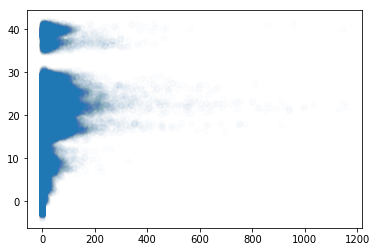

In [44]:
y_pred = model_gs.predict(X_test)


plt.plot(y_test, y_pred, 'o', alpha=0.01)

In [45]:
%%time
model = Pipeline([
    ('ohe', OneHotEncoder(categorical_features=[63, 64], sparse=False)),
    ('mms', MinMaxScaler(feature_range=(0, 1), copy=False)),
    ('rf', RandomForestRegressor(n_estimators=10))
])

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(
    features_, 
    target_out, 
    test_size=0.2, 
    random_state=42)

model_gs = GridSearchCV(
    model,
    {'rf__n_estimators': [10, 50, 100]},
    cv=5,
    n_jobs=2
)

CPU times: user 1.32 s, sys: 1.67 s, total: 2.99 s
Wall time: 3.71 s


In [46]:
model_gs.fit(X_train, y_train)
print("Best params: ", model_gs.best_params_)

y_pred = model_gs.predict(X_test)
plt.plot(y_test, y_pred, 'o', alpha=0.01)